<a href="https://colab.research.google.com/github/taobeto/neuroscience/blob/main/Carlos_Alberto_Pena_Sanchez_Lab_Curvas_f_I_VClase.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelo de Hodgkin y Huxley

# Cálculo de Curvas f-I

Este notebook tiene como objetivo calcular las curvas $ f-I $ (frecuencia-corriente), así como aprender a hacer análisis de tiempos de disparo.

### Ejercicio 1:

Construir la curva f-I del modelo de HH con los parámetros dados en la clase anterior. A qué tipo de clase de excitabilidad corresponde el modelo de HH con los parámetros estudiados?

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.signal import find_peaks


def Iext(t, Iextesco):
  if t >= 0 and t <= 300 :
    return Iextesco
  else:
    return 0



def Hodgkin_Huxley(t, X, Iextesco, Cm, gna, gk, gl, Ena, Ek, El):

  V = X[0]
  n = X[1]
  m = X[2]
  h = X[3]


  I_ext= Iext(t, Iextesco)

  an = 0.01*(V+55)/(1-np.exp(-(V+55)/10))
  bn = 0.125*np.exp(-(V+65)/80)
  am = 0.1*(V+40)/(1-np.exp(-(V+40)/10))
  bm = 4*np.exp(-(V+65)/18)
  ah = 0.07*np.exp(-(V+65)/20)
  bh = 1/(1+np.exp(-(V+35)/10))


  ninf = an/(an+bn)
  tn = 1/(an+bn)

  minf = am/(am+bm)
  tm = 1/(am+bm)

  hinf = ah/(ah+bh)
  th = 1/(ah+bh)

  dndt = (ninf-n)/tn
  dmdt = (minf-m)/tm
  dhdt =(hinf-h)/th

  Ina = gna*m**3*h*(V-Ena)
  Ik = gk*n**4*(V-Ek)
  Il = gl*(V-El)


  dVdt = (I_ext -(Ina + Ik + Il))/Cm
  return [dVdt, dndt, dmdt, dhdt]




def simular(num_experimentos = 50):

  tspan = [0, 300]

  tdenso = np.linspace(tspan[0], tspan[-1], 5000)

  Cm,gna,gk,gl,Ena,Ek,El = 1,120,36,0.3,50,-77,-50
  X0 = [-65,0.3365,0.05885,0.5519]

  Iexco = []
  V = []
  for i in range(num_experimentos):
    Iextesco = 0.3*i

    solucion = solve_ivp(Hodgkin_Huxley, tspan, X0,
                      args = (Iextesco,Cm,gna,gk,gl,Ena,Ek,El), dense_output = True, rtol =  10**-6)

    tdenso = np.linspace(tspan[0], tspan[-1], 5000)
    v, n, m, h = solucion.sol(tdenso)
    V.append(v)
    Iexco.append(Iextesco)

  return  Iexco, tdenso, V

def extraer_spikes(Iextesco, tdenso, V, experi = 50):
  Iext=[]
  t_spikes=[]
  v_spikes = []
  for i in range(experi):
    peakID,_ = find_peaks(V[i],height=10)
    Iext.append(Iextesco[i])
    t_spikes.append(tdenso[peakID])
    v_spikes.append(V[i][peakID])
  return Iext, t_spikes, v_spikes







In [ ]:
def encontrar_frecuencias(Iext, v_spike,t_spike, experimentos=50):
  frecuencias = []
  Imedidas = []
  for i in range(experimentos):
    if len(v_spike[i]) < 2:
      continue
    else:
      Imedidas.append(Iext[i])
      intervalos_spike = np.diff(t_spike[i])
      periodo_spike = np.mean(intervalos_spike)*0.001 # convertir a segundos
      frecuencia_spike = 1/periodo_spike
      frecuencias.append(frecuencia_spike)
  return Imedidas, frecuencias

Iextesco, tdenso, V = simular()
valor_spike, tiempos_spike, voltajes_spike = extraer_spikes(Iextesco, tdenso, V)

Imedidas, frecuencias = encontrar_frecuencias(valor_spike, voltajes_spike, tiempos_spike)

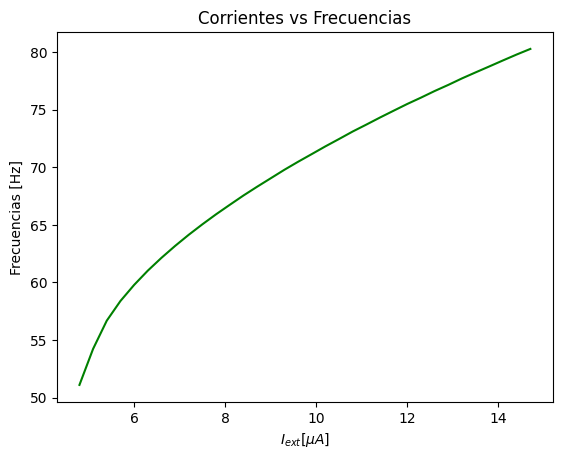

In [ ]:
plt.plot(Imedidas, frecuencias, color = 'g')
plt.title('Corrientes vs Frecuencias')
plt.xlabel('$I_{ext} [\mu A]$')
plt.ylabel('Frecuencias [Hz]')
plt.show()

### Ejercicio 2:

A continuación se le presenta un experimento real de electorfisología en el que su colega biólogo ha hecho un experimento aplicando un protocolo de estimulación a una neurona, consistente en varios valores de corriente constante. Su colega le solicita que le indique si la neurona que ha registrado es de tipo I o tipo II.

Realice el análisis para determinarlo. Para ello

1. Compute la curva $f - I$ de esta neurona
2. Muestre dos curvas representativas mostrando cómo es la traza de tiempo del voltaje para una corriente subumbral y una supraumbral.


In [ ]:
!pip install pyabf
import pyabf



El dipsoitivo que se usa para hacer registros electrofisiológicos almacena los datos en formato *abf*, para poder leer los datos ejecute el siguiente *snippet*

In [ ]:
abf = pyabf.ABF('SpikesAndBursts_PFC_Pvalb_APs_01.abf')
print(abf)

ABF (v2.6) with 2 channels (mV, pA), sampled at 10.0 kHz, containing 13 sweeps, having no tags, with a total length of 0.65 minutes, recorded with protocol "CC_20pA_100_340pA_500ms".


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


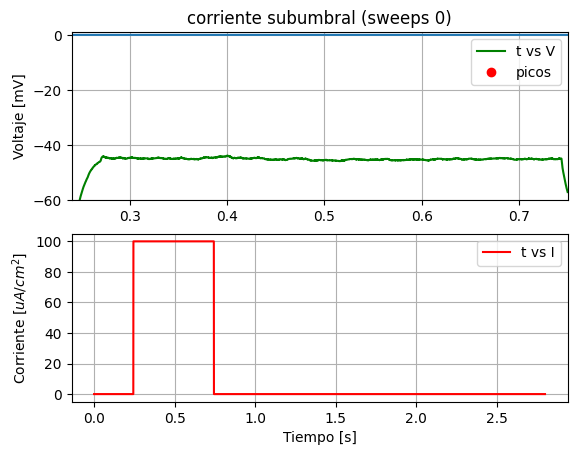

In [ ]:

def encontrar_picos1(V,td1,sencibilidad):   #funcion 2                        #funcion encontrar picos de los spikes modificada

    Peaks_id,_ = find_peaks(V, height= sencibilidad)                          #esta funcion admite un cambio de tiempo y su evalucion, ademas de un umbral donde no contara picos
    Valorespico = V[Peaks_id]
    tiempo_picos = td1[Peaks_id]
    return Valorespico,tiempo_picos,Peaks_id
#buscando el umbral para picos

abf.setSweep(0)                     #seleccion de sweet
tiempo = abf.sweepX                 #extraccion de variables
voltaje = abf.sweepY
corriente = abf.sweepC
linea= [0]*len(tiempo)
Valorespico1,tiempo_picos1,Peaks_id1 = encontrar_picos1(voltaje,tiempo,0)   #encontrando picos, asigno un umbral muy bajo para ver que sucede


plt.subplot(2,1,1)
plt.title('corriente subumbral (sweeps 0)')
plt.plot(tiempo,linea)
plt.plot(tiempo, voltaje, color = 'g', label = 't vs V')
plt.plot(tiempo_picos1,Valorespico1, 'o', color = 'red', label = 'picos') #no hay picos por el umbral programado previamente
plt,plt.legend()
plt.xlim(0.24,0.75)
plt.ylim(-60,1)
plt.ylabel('Voltaje [mV]')
plt.grid()


plt.subplot(2,1,2)
plt.plot(tiempo, corriente, color = 'r', label = 't vs I')
plt.legend()
plt.xlabel('Tiempo [s]')
plt.ylabel('Corriente $[uA/cm^2]$')
plt.grid()
plt.show()


#gran cantidad de puntos que no corresponden a spikes


In [ ]:
def encontrar_frecuencias(corrientes, voltajes,tiempos, experimentos=200):
  frecuencias = []
  Imedidas = []
  for i in range(experimentos):
    I_prom = np.mean(corrientes[i])
    Imedidas.append(I_prom)

    peaks_indices, _ = find_peaks(voltajes[i], height=10)
    if len(peaks_indices) < 2:
      frecuencias.append(0)
    else:
      tiempos_pikes = tiempos[i][peaks_indices]
      intervalos = np.diff(tiempos_pikes)
      periodo_promedio = np.mean(intervalos)
      frecuencia = 1 /periodo_promedio
      frecuencias.append(frecuencia)
  return Imedidas, frecuencias

Como puede notar el objeto abf importado contiene información sobre 2 canales. Uno mide el potencial de membrana, mientras el otro registra la corriente aplicada, ambas en función del tiempo, con una frecuencia de muestreo de 10kHz. El experimento consiste en 13 *sweeps* o protocolos diferentes. Para acceder a la información del *sweep* i-ésimo, deberá llamar el método

abf.setSweep(i)

Una vez establecido el sweep que desea analizar la información requerida la encontrará en los siguiente atributos:

- tiempo -> abf.sweepX
- voltaje -> abf.sweepY
- corriente -> abf.sweepC

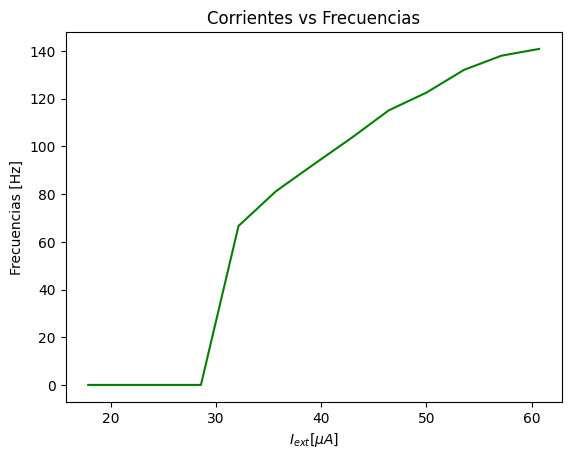

In [ ]:
valor_spike = []
tiempos_spike = []
voltajes_spike = []
for i in range(0,13):
  abf.setSweep(i)
  valor_spike.append(abf.sweepC.copy())
  tiempos_spike.append(abf.sweepX.copy())
  voltajes_spike.append(abf.sweepY.copy())


Imedidas, frecuencias = encontrar_frecuencias(valor_spike, voltajes_spike, tiempos_spike, 13)

plt.plot(Imedidas, frecuencias, color = 'g')
plt.title('Corrientes vs Frecuencias')
plt.xlabel('$I_{ext} [\mu A]$')
plt.ylabel('Frecuencias [Hz]')
plt.show()